In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import shapely
import random
import os

from shapely.geometry import shape
from shapely.geometry import Point

import pystac_client
import planetary_computer as pc

import random
random.seed(10)

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* THIS NEEDS TO BE DYNAMIC, NOT HARDCODED *********
# ********* HERE I KNOW WHICH IMAGE TEHSE POINTS ARE IN ******
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
# we only need the image at this point to access the datasets crs

In [3]:
fp = os.path.join(os.getcwd(),'aux_data','campuspoint2018polys/campuspoint2018polys.shp')
polys = gpd.read_file(fp)
polys.head()

polys['iceplant'] = polys.id.apply(lambda x : 1 if x<10 else 0) 
polys.drop('id',axis=1,inplace=True)
polys.to_crs(ds.crs,inplace=True)
polys

,geometry,iceplant
0,"POLYGON ((238347.176 3810851.075, 238350.922 3...",1
1,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1
2,"POLYGON ((238527.281 3810831.411, 238531.339 3...",1
3,"POLYGON ((238513.547 3810846.706, 238512.610 3...",1
4,"POLYGON ((238419.905 3810816.740, 238438.945 3...",1
5,"POLYGON ((239087.262 3811796.777, 239089.759 3...",1
6,"POLYGON ((239498.195 3812050.546, 239512.397 3...",1
7,"POLYGON ((239470.102 3812026.823, 239478.686 3...",1
8,"POLYGON ((239974.833 3812163.541, 239974.209 3...",1
9,"POLYGON ((238375.113 3810886.737, 238379.482 3...",0


In [4]:
polys['area'] = polys.geometry.apply(lambda p : p.area)
polys.sort_values(by='area',ascending=False,inplace=True)
polys.reset_index(drop=True,inplace=True)
polys.head()

,geometry,iceplant,area
0,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1,925.592242
1,"POLYGON ((238593.923 3811127.708, 238612.964 3...",0,918.966999
2,"POLYGON ((238667.901 3811241.951, 238688.814 3...",0,850.911637
3,"POLYGON ((239249.107 3811881.522, 239285.627 3...",0,787.289556
4,"POLYGON ((238564.270 3811247.257, 238588.617 3...",0,740.278963


<AxesSubplot:>

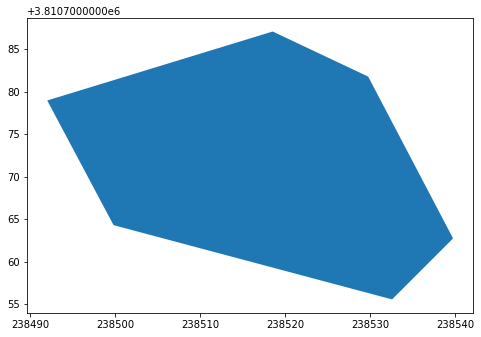

In [5]:
# pick biggest polygon
biggest = polys.filter(items=[0],axis=0).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)

### Figuring out #pixels covered by polygon
Checking the CRS of the polygon we can see that the axes are in meters, so the areas we get from the shapely function `polygon.area` is in meters too. 

Using the resolution for the raster we can know how much area a single pixel covers. 

In [17]:
print('NAIP resolution:',ds.res,'\n')
biggest.crs

NAIP resolution: (0.6, 0.6) 



<Derived Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
def random_pts_poly(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  

<AxesSubplot:>

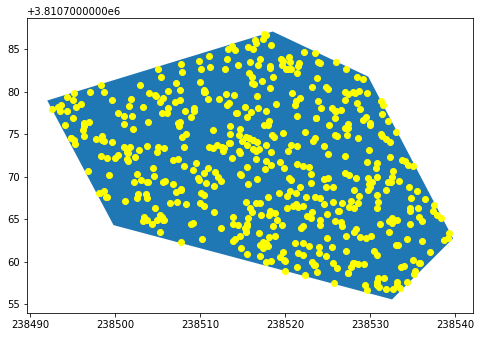

In [26]:
proportion = 0.2
# calculating how many pixels are there in the polygon (approx), by dividing the area of poly by area of a single pixel
pixels_in_poly = int(biggest.area/(ds.res[0]*ds.res[1])) 
N= pixels_in_poly * proportion
# BEFORE N=25
# DEFINE NUMBER OF RANDOM POINTS TO BE SELECTED ON BIGGEST POLYGON
# the rest of the polygons will have a number of polygons proportional to their area

points = random_pts_poly(N,biggest['geometry'][0])
# ********** SIMPLIFY THIS ***************
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points
geo_points.set_crs(polys.crs,inplace=True)
# *******************************************************************

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)
geo_points.plot(ax=ax,color='yellow')

In [28]:
big_area = biggest['geometry'][0].area
polys['num_random_pts'] = polys.area.apply(lambda a : int(a/big_area*N))
polys.drop('area',axis=1,inplace=True)
polys

,geometry,iceplant,num_random_pts
0,"POLYGON ((238518.541 3810787.088, 238529.778 3...",1,514
1,"POLYGON ((238593.923 3811127.708, 238612.964 3...",0,510
2,"POLYGON ((238667.901 3811241.951, 238688.814 3...",0,472
3,"POLYGON ((239249.107 3811881.522, 239285.627 3...",0,437
4,"POLYGON ((238564.270 3811247.257, 238588.617 3...",0,411
5,"POLYGON ((239545.016 3812095.025, 239571.860 3...",0,331
6,"POLYGON ((238375.113 3810886.737, 238379.482 3...",0,299
7,"POLYGON ((238513.547 3810846.706, 238512.610 3...",1,276
8,"POLYGON ((239498.195 3812050.546, 239512.397 3...",1,272
9,"POLYGON ((238730.016 3811157.986, 238745.311 3...",0,265


In [29]:
samples = []
for i in range(0,polys.shape[0]):
    poly = polys['geometry'][i]
    N = polys['num_random_pts'][i]
    
    points = random_pts_poly(N,poly)
    sample = pd.DataFrame({
        'geometry': pd.Series(points), 
        'iceplant':pd.Series(np.full(N,polys['iceplant'][i]))
                 })
    sample['xy']=sample.geometry.apply(lambda p :(p.x, p.y))
    
    data_generator = ds.sample(sample.xy)
    data = []
    for i in data_generator:
        data.append(i)
    data = np.vstack(data)
    data = pd.DataFrame(data, columns=['r','g','b','nifr'])
    
    sample = pd.concat([sample,data],axis=1)
    samples.append(sample)


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interfac

In [30]:
train_set = pd.concat(samples)
train_set['x']= train_set.geometry.apply(lambda p : p.x)
train_set['y']= train_set.geometry.apply(lambda p : p.y)
train_set.drop('xy',axis=1,inplace=True)
train_set.reset_index(drop=True,inplace=True)
train_set

,geometry,iceplant,r,g,b,nifr,x,y
0,POINT (238502.90962098842 3810767.0101709925),1,87,80,87,140,238502.909621,3.810767e+06
1,POINT (238531.08502453016 3810765.502552128),1,85,81,84,149,238531.085025,3.810766e+06
2,POINT (238514.12151877338 3810770.2447426612),1,96,83,89,149,238514.121519,3.810770e+06
3,POINT (238494.7719131412 3810776.858465532),1,93,89,86,161,238494.771913,3.810777e+06
4,POINT (238504.7700446698 3810767.611043045),1,84,78,85,135,238504.770045,3.810768e+06
...,...,...,...,...,...,...,...,...
4784,POINT (238528.64940991733 3810823.989051403),1,87,83,83,159,238528.649410,3.810824e+06
4785,POINT (238523.83379692418 3810824.088622455),1,86,84,84,164,238523.833797,3.810824e+06
4786,POINT (238526.3225788108 3810826.9657032588),1,84,82,85,147,238526.322579,3.810827e+06
4787,POINT (238528.57192852139 3810829.298083701),1,92,81,85,151,238528.571929,3.810829e+06


In [31]:
train_set = train_set[['geometry','x','y','r','g','b','nifr','iceplant']]
train_set

,geometry,x,y,r,g,b,nifr,iceplant
0,POINT (238502.90962098842 3810767.0101709925),238502.909621,3.810767e+06,87,80,87,140,1
1,POINT (238531.08502453016 3810765.502552128),238531.085025,3.810766e+06,85,81,84,149,1
2,POINT (238514.12151877338 3810770.2447426612),238514.121519,3.810770e+06,96,83,89,149,1
3,POINT (238494.7719131412 3810776.858465532),238494.771913,3.810777e+06,93,89,86,161,1
4,POINT (238504.7700446698 3810767.611043045),238504.770045,3.810768e+06,84,78,85,135,1
...,...,...,...,...,...,...,...,...
4784,POINT (238528.64940991733 3810823.989051403),238528.649410,3.810824e+06,87,83,83,159,1
4785,POINT (238523.83379692418 3810824.088622455),238523.833797,3.810824e+06,86,84,84,164,1
4786,POINT (238526.3225788108 3810826.9657032588),238526.322579,3.810827e+06,84,82,85,147,1
4787,POINT (238528.57192852139 3810829.298083701),238528.571929,3.810829e+06,92,81,85,151,1


In [12]:
type(train_set)

pandas.core.frame.DataFrame

In [32]:
train_fp = os.path.join(os.getcwd(),'aux_data','trainset_BIG.csv')
train_set.to_csv(train_fp)

In [34]:
os.getcwd()

'/home/jovyan/msai4earth-esa/iceplant_detection/training_set'